In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import progressbar

from HelperAndMechanics import *
from scipy.ndimage import gaussian_filter1d
import jax.numpy as jnp
from jax import jit

# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 10}
plt.rc('font', **font)

plt.rc('text', usetex=True)

In [11]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_var_xl.h5', 'r') as f:
    # x_temp = f['x_temp'][:]
    # x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()
    
N = T.shape[0]
x_temp = 0
x_cm_temp = 0


dA_diff = np.diff(dA, axis=0)
min_derivative = np.min(dA_diff,axis=0)
max_derivative = np.max(dA_diff,axis=0)
dA_diff = (dA_diff - min_derivative)/(max_derivative-min_derivative)

In [28]:
t_start,t_stop = 0,12000#T.shape[0]-3000
i,j = 5,15
T.shape[0]

25000

In [29]:
diff = 0
start_indx = 0
while diff < 1000: 
    dA_test = dA[t_stop+500:,i,j]
    T_test = T[t_stop+500:,i,j]
    maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
    minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
    max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx)
    diff = minima_temp0[min_indx+1]-maxima_temp0[max_indx]
    print(diff)
    start_indx += 1
    
    t_start_fit = t_stop + 500 + maxima_temp0[max_indx] - 400
    t_stop_fit = t_stop + 500+ minima_temp0[min_indx+1] + 800
    print(t_start_fit,t_stop_fit)

dA_r_0_raw = dA[t_start_fit:t_stop_fit,i,j] - dA[t_start_fit,i,j]
dA_r_0_der_raw = np.append(np.diff(dA[t_start_fit:t_stop_fit,i,j],axis = 0),np.diff(dA[t_start_fit:t_stop_fit,i,j],axis = 0)[-1])
dA_r_05_raw = np.array([dA[t_start_fit:t_stop_fit,i,j],dA[t_start_fit:t_stop_fit,i,j+1],dA[t_start_fit:t_stop_fit,i+1,j],dA[t_start_fit:t_stop_fit,i-1,j],dA[t_start_fit:t_stop_fit,i,j-1]])
dA_r_05_der_raw = np.append(np.diff(dA_r_05_raw,axis = 1),np.diff(dA_r_05_raw,axis = 1)[:,-1].reshape(5,1),axis = 1)


753
13556 15509
753
13556 15509
753
13556 15509
1104
13930 16234


In [20]:
no_points,no_dt, delta_t = 10, 30, 20

In [21]:
#x_train,x_fit, y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_0_raw,i,j,no_dt,no_points,delta_t)
#y_out = euclidean_distance_trajectory(x_fit, x_train,y_train)
x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_0_der_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_0_derivative")
y_out_diff = euclidean_distance_trajectory(x_fit, x_train,y_train)
#x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_05_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_05")
#y_out_05 = euclidean_distance_trajectory(x_fit, x_train,y_train)
#x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_05_der_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_05_derivative")
#y_out_05_diff = euclidean_distance_trajectory(x_fit, x_train,y_train)

x_arr_train_flattended.shape= (1, 31, 82, 12000)


In [25]:
T_fit_raw = T[t_start_fit:t_stop_fit,i,j]

plt.figure(figsize=(15,8))
#plt.plot(y_out,label='Prediction')
plt.plot(y_out_diff,label='Prediction with derivative')
#plt.plot(y_out_05,label='Prediction with 5 points')
#plt.plot(y_out_05_diff,label='Prediction with 5 points and derivative')
plt.plot(T_fit_raw,label='Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=1)
#plt.savefig('test.png')

NameError: name 'y_out_diff' is not defined

<Figure size 1500x800 with 0 Axes>

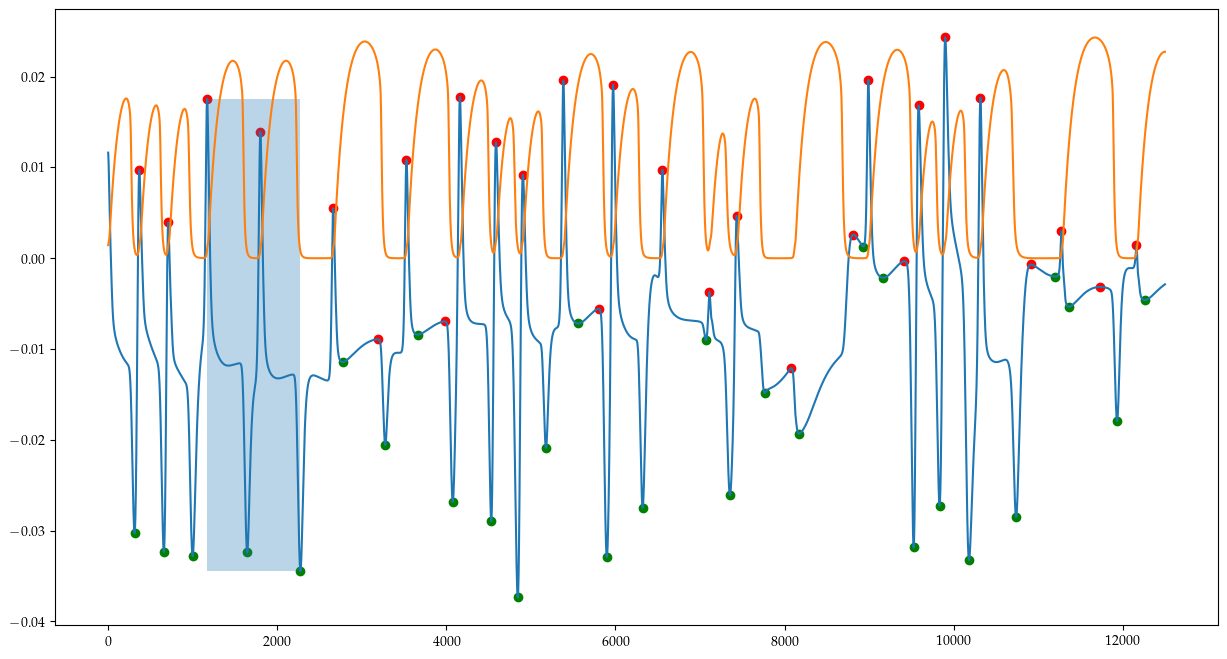

In [27]:
plt.figure(figsize=(15,8))
plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx+1]],dA_test[minima_temp0[min_indx+1]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))

In [7]:
losses = np.load('../data/SpringMassModel/EtaSweep/eta_sweepT_rec_xl_2.npy')

/tmp/ipykernel_15028/905356333.py:4: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(losses[:, :, :, 0])
/tmp/ipykernel_15028/905356333.py:5: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(losses[:, :, :, 0])
/tmp/ipykernel_15028/905356333.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make space for the colorbar


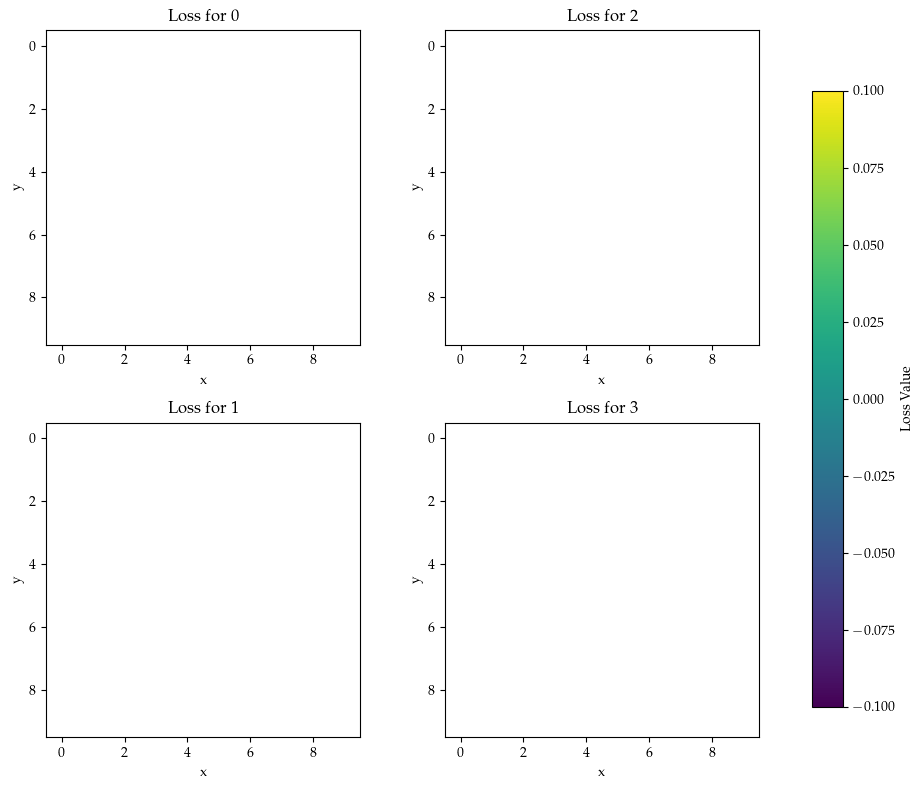

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Find the global vmin and vmax for consistent color scaling
vmin = np.nanmin(losses[:, :, :, 0])
vmax = np.nanmax(losses[:, :, :, 0])

# Create the subplots and use a single colorbar
for i in range(2):
    for j in range(2):
        im = axs[i, j].imshow(
            losses[:, :, i + j * 2, 1],
            cmap='viridis',
            interpolation='nearest',
            vmin=vmin,
            vmax=vmax
        )
        axs[i, j].set_title(f'Loss for {i + j * 2}')
        axs[i, j].set_xlabel('x')
        axs[i, j].set_ylabel('y')

# Add a single colorbar outside the figure
cbar = fig.colorbar(
    im,
    ax=axs,
    orientation='vertical',  # 'horizontal' for below the figure
    fraction=0.08,           # Fraction of original axes height
    pad=0.1                  # Padding between the figure and the colorbar
)
cbar.set_label('Loss Value')

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make space for the colorbar
plt.show()

